In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [99]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.filtering_sampling import solve_updated_mod

import numpy as np
import pandas as pd

import os
from itertools import chain

from config import plt_config
plt.rcParams.update(plt_config)

globals 

In [100]:
plot_vars = ['Y', 'C', 'I', 'L', 'w', 'r', 'pi', 'lambda']

load model

In [120]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors
mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors},
    # 'mod4_rbc_flabour_2': {'params': mod4_params,
                           # 'priors': mod4_priors},
    # 'mod5_nk_vanilla': {'params': mod5_params,
                            # 'priors': mod5_priors},
    # 'mod5_nk_capital': {'params': mod5_params,
    #                         'priors': mod5_priors},
    'mod5_nk_simpTaylor_2': {'params': mod5_params,
                            'priors': mod5_priors},
}

# load model
for key in mods.keys():
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=True)
    # mods[key]['mod'].free_param_dict.update(mods[key]['params'])

# solve model
for item in mods.keys():
    _, mods[item]['mod'] = solve_updated_mod(mods[item]['mod'], verbose=True)
    assert _ == True

Model Building Complete.
Found:
	14 equations
	14 variables
	The following variables were eliminated at user request:
		TC_t
	The following "variables" were defined as constants and have been substituted away:
		B_t
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	11 parameters
		 0 / 11 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.

Steady state found! Sum of squared residuals is 6.879760541867044e-21
Solution found, sum of squared residuals:  9.02710347761435e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 7 eigenvalues greater than one in modulus and 5 forward-looking variables.
Blanchard-Kahn condition is satisfied.


covariance

In [121]:
# _ = plot_vars.copy()
# _.append('pi')
# for key in mods.keys():
#     sigma = mods[key]['mod'].compute_stationary_covariance_matrix()
#     mods[key]['cov_matrix'] = sigma
#     if 'nk' in key:
#         plt.figure(figsize=(5, 4))
#         sns.heatmap(sigma.loc[_, _], cmap='winter', annot=True, annot_kws={"fontsize":7})
#         plt.title(key, size=8)
#         plt.tight_layout()
        
#         print(sigma.loc['pi', 'Y'])

IRF

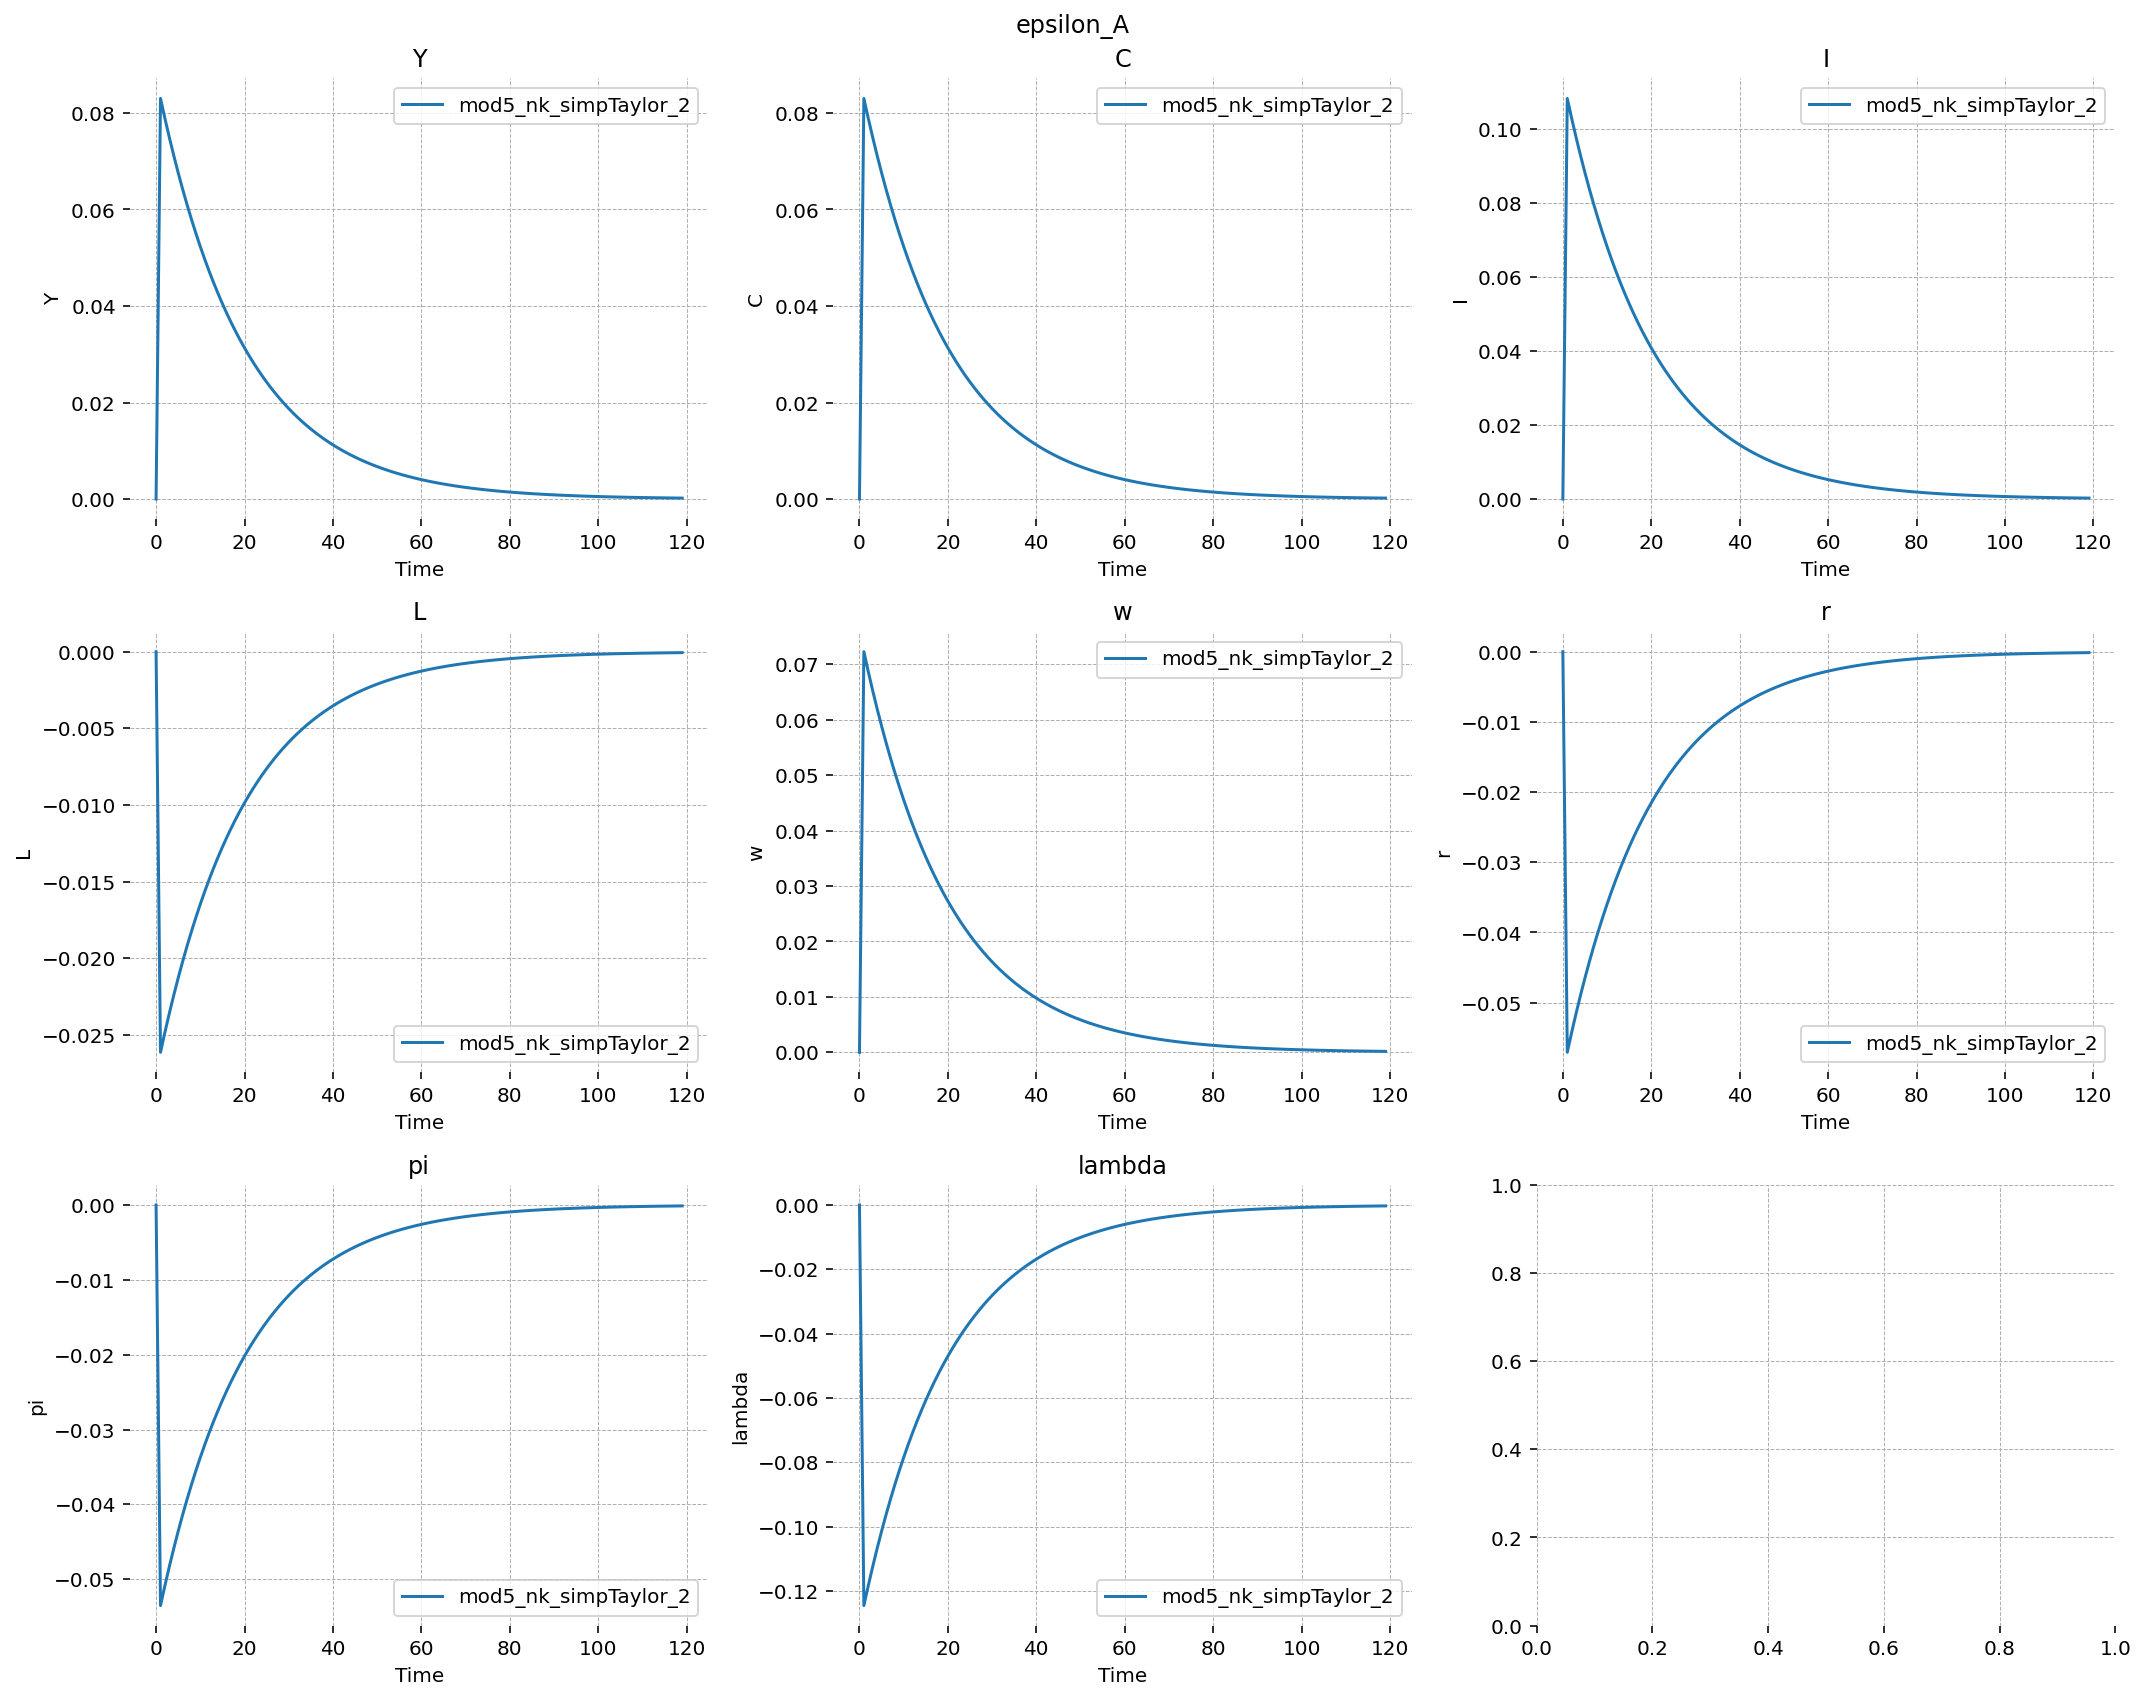

In [122]:
shock_size = .1
sim_length = 120

# get irf for each model
for key in mods.keys():
    mods[key]['irf'] = mods[key]['mod'].impulse_response_function(simulation_length=sim_length, shock_size=shock_size)

# set plotting shock
shocks = ['epsilon_A'] #, 'epsilon_R', 'epsilon_pi']
p_vars = plot_vars.copy()
for shock in shocks:
    irfs_list = []
    legend = []
    p_vars = plot_vars.copy()
    for key in mods.keys(): # ['mod5_nk_vanilla', 'mod5_nk_capital']:
        try:
            irfs_list.append(mods[key]['irf'].unstack().loc[:, shock].unstack().copy())
            legend.append(key)
            p_vars = [item for item in p_vars if item in [var.base_name for var in mods[key]['mod'].variables]]
        except KeyError:
            continue
    
    # plot shocks
    plot_dfs([df[p_vars] for df in irfs_list],
             sns.lineplot,
             figsize=(15, 4), 
             fig_title=shock,
             legend=legend
            )